<a href="https://colab.research.google.com/github/nicholas-dinicola/Forecasting-stock-prices-based-on-semantic-analysis-of-business-news-and-social-media-posts-/blob/main/ML_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pipinstall xgboost 

/bin/bash: pipinstall: command not found


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas_datareader as pdr
from datetime import datetime
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import time
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mean Directional Accuracy
def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

# Load the TSLA Historical Price Data 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tlsa_stock = pd.read_csv("/content/drive/MyDrive/TLSA_stock.csv")
tlsa_stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-01-04,46.276001,43.799999,46.144001,44.681999,34135500.0,44.681999
1,2016-01-05,45.377998,44.000000,45.271999,44.686001,15934000.0,44.686001
2,2016-01-06,44.009998,43.195999,44.000000,43.807999,18895500.0,43.807999
3,2016-01-07,43.688000,42.734001,42.838001,43.130001,17771500.0,43.130001
4,2016-01-08,44.088001,42.153999,43.571999,42.200001,18140500.0,42.200001


In [5]:
tlsa_stock["Date"] = pd.to_datetime(tlsa_stock["Date"], format="%Y-%m-%d")
tlsa_stock.set_index("Date", inplace=True)
tlsa_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,46.276001,43.799999,46.144001,44.681999,34135500.0,44.681999
2016-01-05,45.377998,44.000000,45.271999,44.686001,15934000.0,44.686001
2016-01-06,44.009998,43.195999,44.000000,43.807999,18895500.0,43.807999
2016-01-07,43.688000,42.734001,42.838001,43.130001,17771500.0,43.130001
2016-01-08,44.088001,42.153999,43.571999,42.200001,18140500.0,42.200001


In [6]:
tlsa_stock.isnull().any().sum()

0

Text(0.5, 1.0, 'TSLA Close Stock Price')

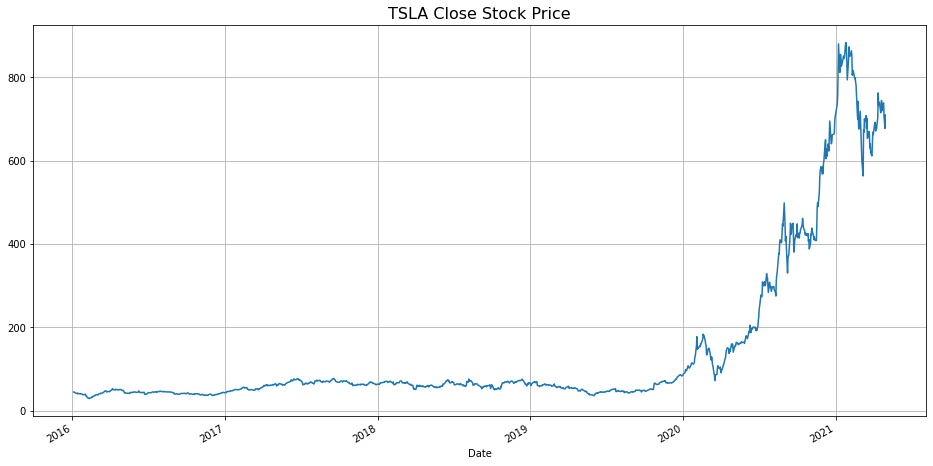

In [7]:
tlsa_stock["Close"].plot(figsize=(16, 8))
plt.grid(True)
plt.title("TSLA Close Stock Price", fontsize=16)

Data after 2020/01/01 became too volatile, thereby i will not include those data in the model. 

In [8]:
final_tesla = tlsa_stock[tlsa_stock.index < "2019/09/01"]
final_tesla.index.min(), final_tesla.index.max()

(Timestamp('2016-01-04 00:00:00'), Timestamp('2019-08-30 00:00:00'))

Text(0.5, 1.0, 'TSLA Close Stock Price')

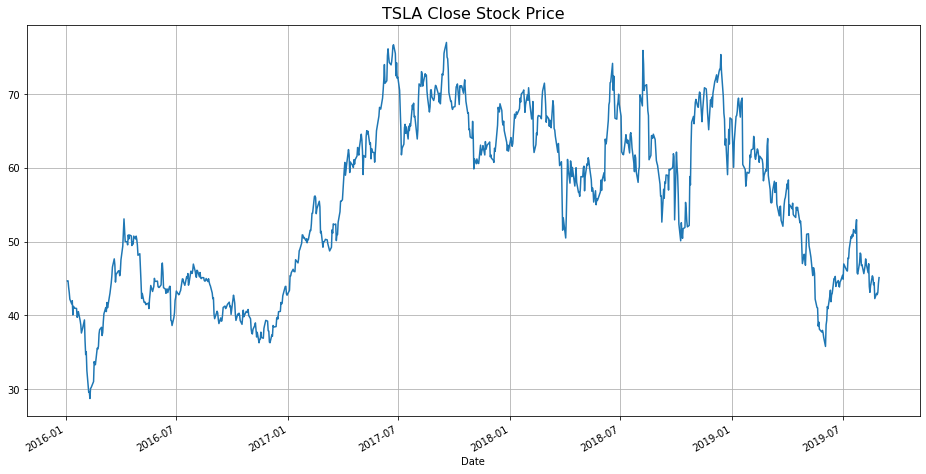

In [9]:
final_tesla["Close"].plot(figsize=(16, 8))
plt.grid(True)
plt.title("TSLA Close Stock Price", fontsize=16)

In [10]:
final_tesla.shape

(922, 6)

# *Predict the Close Price only using stock price data*

In [11]:
train_set, test_set = train_test_split(final_tesla["Close"], test_size=0.1, random_state=42, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

829 train and 93 test instances


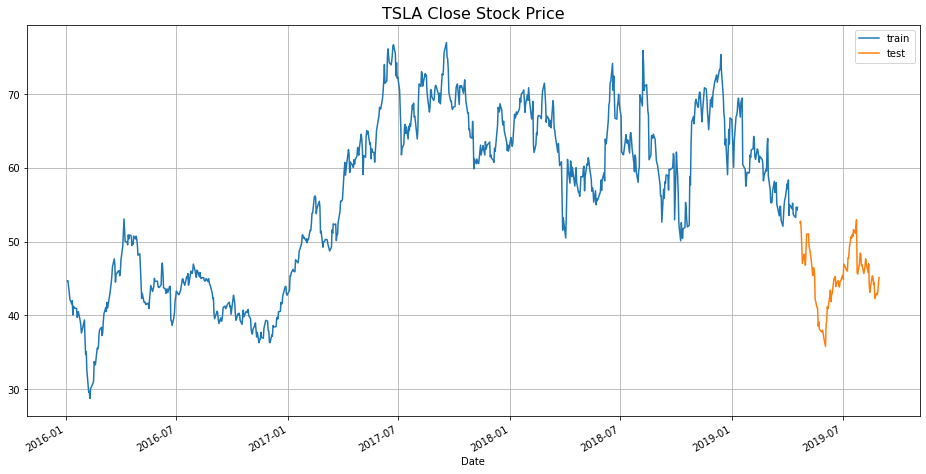

In [12]:
pd.DataFrame({"train":train_set, "test":test_set}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price", fontsize=16)
plt.grid(True)

## *Check for Stationarity*

In [13]:
# On Levels 
adf_pval = adfuller(train_set)[1]
print(f"ADF, p-value: {adf_pval}")
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set)
print(f"KPSS, p-value: {kpss_pval}")

ADF, p-value: 0.19748062170318614
KPSS, p-value: 0.01


In [14]:
# On Logs
logs = np.log(train_set)
adf_pval = adfuller(logs)[1]
print(f"ADF, p-value: {adf_pval}")
kpss_stat, kpss_pval, lags, crit_vals = kpss(logs)
print(f"KPSS, p-value: {kpss_pval}")

ADF, p-value: 0.26789421960640797
KPSS, p-value: 0.01


In [15]:
# Differencing 
train_diff = train_set.diff().dropna()
adf_pval = adfuller(train_diff)[1]
print(f"ADF, p-value: {adf_pval}")
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
print(f"KPSS, p-value: {kpss_pval}")

ADF, p-value: 0.0
KPSS, p-value: 0.1


In [16]:
train_log = np.log(train_set)
test_log = np.log(test_set)

In [17]:
# Apply differencing to the treaiinin and testing  
train_diff = train_log.diff().dropna()
test_diff = test_log.diff().dropna()

# chech the shape of them 
train_diff.shape, test_diff.shape

((828,), (92,))

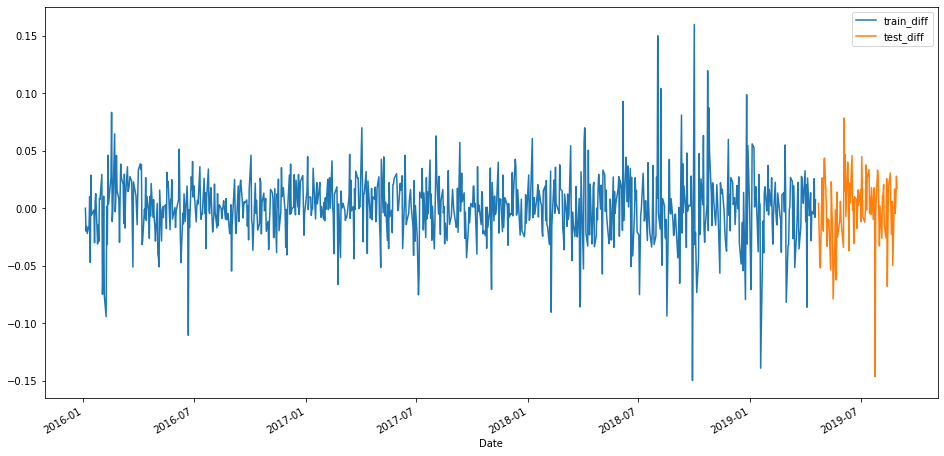

In [18]:
pd.DataFrame({"train_diff": train_diff, "test_diff": test_diff}).plot(figsize=(16, 8))

# Build Simple LSTM with AR vars 

# Baseline

### Percistence Baseline

In [19]:
mse = mean_squared_error(test_set[1:], test_set.shift()[1:])
np.sqrt(mse)

1.427418852120096

In [20]:
mda = get_mda(test_diff[1:], test_diff.shift()[1:])
mda

0.3111111111111111

### Mean baseline

The mean baseline calculates the mean of the series in the training data and predicts the value for each test observation.

In [21]:
# No stationaize data 
train_diff_mean = train_diff.mean()
train_diff_mean

mse = mean_squared_error(test_diff, [train_diff_mean]*test_diff.shape[0])
np.sqrt(mse)

0.031236827817641838

In [22]:
mda = get_mda(test_diff, [train_diff_mean]*test_diff.shape[0])
mda

0.0

## Data Transformation - 5 Lags 

In [23]:
# 5 days - from monday to friday (stock market is closedsat and sun)
lags = 5
X_train, y_train, X_test, y_test= [], [], [], []

for x in range(lags, len(train_diff.values.reshape(-1, 1))):
    X_train.append(train_diff.values.reshape(-1, 1)[x-lags:x, 0])
    y_train.append(train_diff.values.reshape(-1, 1)[x, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

for x in range(lags, len(test_diff.values.reshape(-1, 1))):
    X_test.append(test_diff.values.reshape(-1, 1)[x-lags:x, 0])
    y_test.append(test_diff.values.reshape(-1, 1)[x, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((823, 5), (87, 5))

# Modelling

## SVR

In [24]:
svr = SVR(kernel="rbf")

params = [
        {
            "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
            "epsilon": [0.001, 0.01],
            "gamma": [0.01, 0.1, "scale", "auto"], 
            "degree": [3, 6, 9]
        }
        ]


tscv = TimeSeriesSplit(n_splits=5)
svr_cv = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
svr_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 16.825 seconds


In [25]:
svr_cv.best_params_

{'C': 0.001, 'degree': 3, 'epsilon': 0.001, 'gamma': 0.01}

In [26]:
print(f"RMSE CV: {np.sqrt(-svr_cv.best_score_)}")
print(f"RMSE TESTING SET: {np.sqrt(-svr_cv.score(X_test, y_test))}")
print(f"MDA TRAINING SET: {get_mda(y_train, svr_cv.predict(X_train))}")
print(f"MDA TESTING SET: {get_mda(y_test, svr_cv.predict(X_test))}")

RMSE CV: 0.028812046203699017
RMSE TESTING SET: 0.03107495062217147
MDA TRAINING SET: 0.6253041362530414
MDA TESTING SET: 0.627906976744186


Text(0.5, 1.0, 'SVR Evaluation')

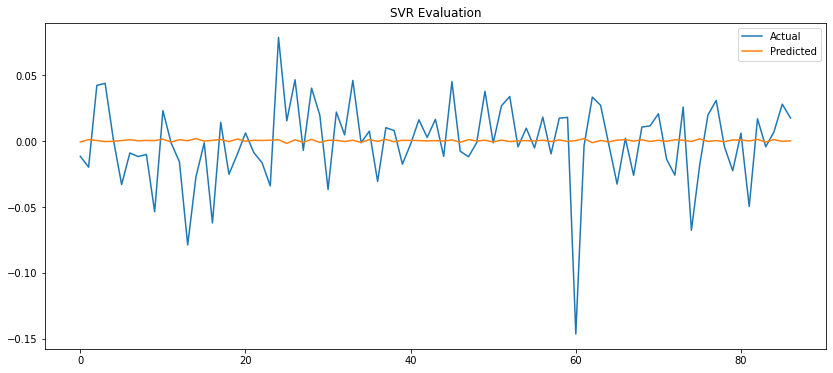

In [27]:
plt.figure(figsize=(14,6))
 
y_hat = svr_cv.predict(X_test)
plt.plot(y_test, label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("SVR Evaluation")

## ADA 

In [32]:
ada = AdaBoostRegressor(random_state=42)

params = {
        "n_estimators": [10, 20, 30, 40, 50, 60, 70], 
        'learning_rate': [0.5, 1, 1.5]
}

tscv = TimeSeriesSplit(n_splits=5)
ada_cv = GridSearchCV(estimator=ada, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True, 
                        n_jobs=-1)

start = time.time()
ada_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 7.646 seconds


In [33]:
ada_cv.best_params_

{'learning_rate': 0.5, 'n_estimators': 10}

In [34]:
print(f"RMSE CV: {np.sqrt(-ada_cv.best_score_)}")
print(f"RMSE TESTING SET: {np.sqrt(-ada_cv.score(X_test, y_test))}")
print(f"MDA TRAINING SET: {get_mda(y_train, ada_cv.predict(X_train))}")
print(f"MDA TESTING SET: {get_mda(y_test, ada_cv.predict(X_test))}")

RMSE CV: 0.02913461514838759
RMSE TESTING SET: 0.031183370737002936
MDA TRAINING SET: 0.32725060827250607
MDA TESTING SET: 0.36046511627906974


Text(0.5, 1.0, 'ADA Evaluation')

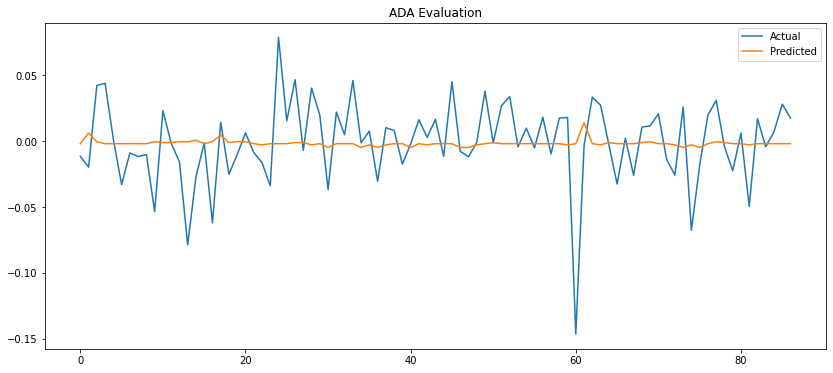

In [35]:
plt.figure(figsize=(14,6))
 
y_hat = ada_cv.predict(X_test)
plt.plot(y_test, label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("ADA Evaluation")

## XGBOOST

In [36]:
xgb = XGBRegressor(random_state=42, n_jobs=-1)

params = {
        "n_estimators": [20, 30, 50, 100, 150, 200, 250, 300, 350], 
        'max_depth': [2, 5, 10, None], 
    'min_child_weight': [1, 2, 3]
}


tscv = TimeSeriesSplit(n_splits=5)
xgb_cv = GridSearchCV(estimator=xgb, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True, 
                        n_jobs=-1)

start = time.time()
xgb_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

[21:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Took 25.746 seconds


In [37]:
xgb_cv.best_params_

{'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 50}

In [38]:
print(f"RMSE CV: {np.sqrt(-xgb_cv.best_score_)}")
print(f"RMSE TESTING SET: {np.sqrt(-xgb_cv.score(X_test, y_test))}")
print(f"MDA TRAINING SET: {get_mda(y_train, xgb_cv.predict(X_train))}")
print(f"MDA TESTING SET: {get_mda(y_test, xgb_cv.predict(X_test))}")

RMSE CV: 0.02978450502747186
RMSE TESTING SET: 0.03207241170641557
MDA TRAINING SET: 0.5389294403892944
MDA TESTING SET: 0.5116279069767442


Text(0.5, 1.0, 'XGB Evaluation')

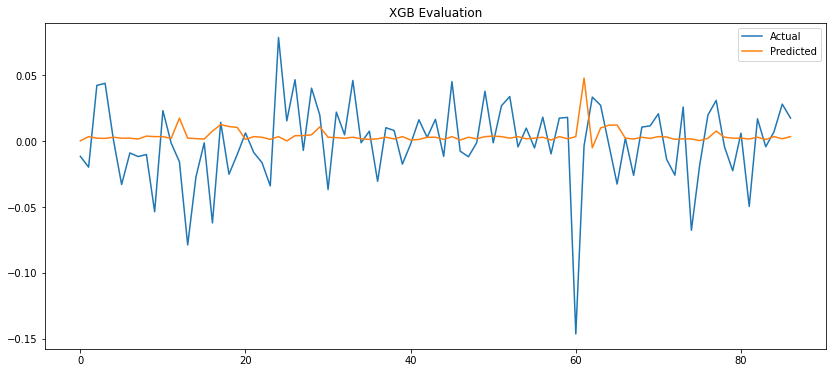

In [39]:
plt.figure(figsize=(14,6))
 
y_hat = xgb_cv.predict(X_test)
plt.plot(y_test, label="Actual")
plt.plot((y_hat), label="Predicted")
plt.legend()
plt.title("XGB Evaluation")